# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

## Optativa: Series de Tiempo en Finanzas

### Examen de Materia Completa - Evaluación (GARCH)

Grupo B08: _Emanuel Nicolás Herrador_

---


## 0. Índice

- [1. Introducción](#1-introducción)
- [2. Desarrollo previo](#2-desarrollo-previo)
- [3. Volatilidad de BTC/EUR](#3-volatilidad-de-btceur)
- [4. PACF](#4-pacf)
- [5. Ajustar GARCH(p, q)](#5-ajustar-garchp-q)
- [6. Rolling Forecast](#6-rolling-forecast)
- [7. Predecir 5 días](#7-predecir-5-días)

## 1. Introducción

El objetivo del presente notebook será resolver el segundo práctico del entregable de Materia Completa correspondiente a la Optativa de *Series de Tiempo en Finanzas*. En este mismo, elegiremos un activo de Yahoo Finance con una historia de al menos 10 años, lo ajustaremos a un modelo GARCH y realizaremos una predicción de 5 valores de su volatilidad.

Las consignas, de forma más específica, se presentan a continuación. Tomando como orientación el jupyter-notebook "GARCH_Modelo_de_activos.ipynb", se pide:

- Seleccionar de Yahoo Finance https://es.finance.yahoo.com/ un activo, un índice, o un tipo de cambio. Descargar una serie con datos diarios que abarque al menos 10 años.
- Aplicar la transformación .pctchange y seleccionar una de las columnas ['Close'] o ['Adj Close']. 
- Si el test ADF no rechaza la existencia de una raíz unitaria para esta transformación, elija otro conjunto de datos.
- Plotee los valores y el cuadrado de los valores, y ajuste un modelo GARCH adecuado. Procure que el modelo sea simple ($p, q <= 3$).
- Muestre en un gráfico que la volatilidad se adecua a la serie que se está modelando.
- Entrene el modelo y realice una predicción de 5 valores de la volatilidad.

## 2. Desarrollo previo


En esta sección nos encargaremos de la importación de las librerías y cargar el .csv desde Yahoo Finance:


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

En este caso, elegiremos enfocarnos en el tipo de cambio *BTC/EUR*, desde el 17 de Septiembre del 2014, hasta el 21 de Septiembre de 2024:

In [2]:
# Descargar datos de BTC-EUR desde Yahoo Finance
ticker = 'BTC-EUR'

end_date = datetime.now()
start_date = end_date - timedelta(days=366 * 10)

btceur = yf.download(ticker, start=start_date, end=end_date)

# Guardar los datos en un archivo CSV
btceur.to_csv('./data/btceur.csv')

# Mostrar los primeros registros y la información
display(btceur.info())
display(btceur.head())

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3658 entries, 2014-09-17 to 2024-09-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3658 non-null   float64
 1   High       3658 non-null   float64
 2   Low        3658 non-null   float64
 3   Close      3658 non-null   float64
 4   Adj Close  3658 non-null   float64
 5   Volume     3658 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 200.0 KB


None

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,359.546204,361.468506,351.586884,355.957367,355.957367,16389166
2014-09-18,355.588409,355.505402,319.789459,328.539368,328.539368,26691849
2014-09-19,328.278503,330.936707,298.921021,307.761139,307.761139,29560103
2014-09-20,307.665253,329.978180,303.931244,318.758972,318.758972,28736826
2014-09-21,318.120514,321.504517,306.502197,310.632446,310.632446,20702625


Lo cual puede visualizarse del siguiente modo:

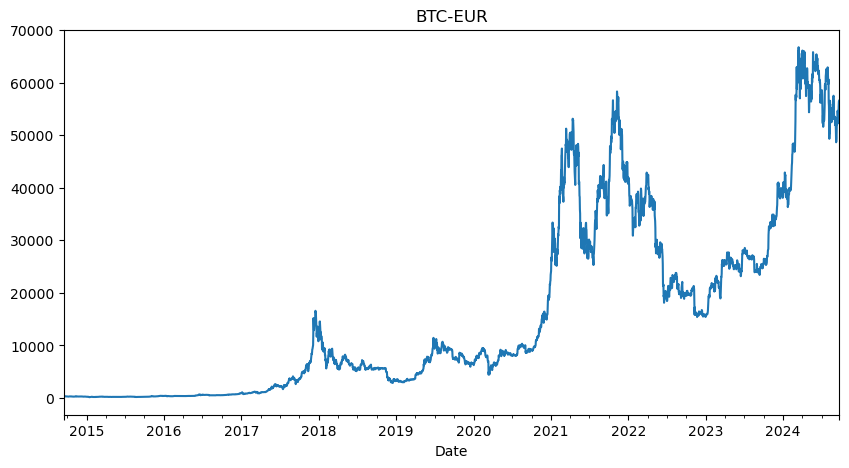

In [3]:
btceur['Adj Close'].plot(figsize=(10, 5), title='BTC-EUR')
plt.show()

## 3. Volatilidad de `BTC/EUR`

Aplicamos la transformación `pct_change` a `Adjusted Close` de BTC/EUR, con el objetivo de obtener la serie de rendimientos diarios. Luego, graficamos la serie para observar su comportamiento.

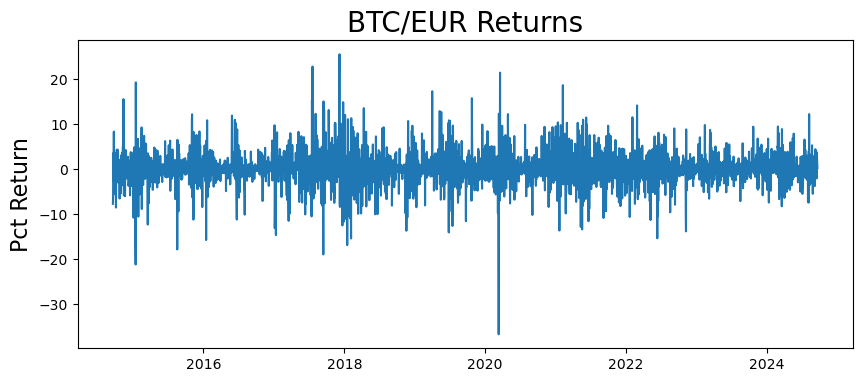

In [4]:
# Obtener los rendimientos diarios
returns = 100 * btceur['Adj Close'].pct_change().dropna()

# Graficar los rendimientos
plt.figure(figsize=(10, 4))

plt.plot(returns)

plt.ylabel('Pct Return', fontsize=16)
plt.title('BTC/EUR Returns', fontsize=20)

plt.show()

Luego, aplicamos el test de Dickey-Fuller aumentado para verificar si la serie de rendimientos es estacionaria y puede ser seleccionada para el ajuste de un modelo GARCH.

In [5]:
result = adfuller(returns)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -61.95566341845407
p-value: 0.0


Luego, entonces, como el p-valor es muy cercano a $0$, podemos rechazar la hipótesis nula de que la serie de rendimientos no es estacionaria. Por lo tanto, podemos proceder a ajustar un modelo GARCH.

## 4. PACF

Ahora, para saber y estimar con qué modelo de GARCH comenzar ajustando, se procede a realizar el gráfico de la función de autocorrelación parcial (PACF) de la serie de rendimientos al cuadrado.

Este truco nos permite identificar los valores de $p$ y $q$ para el modelo GARCH(p, q) que se ajustará inicialmente a la serie de rendimientos al cuadrado. Posteriormente, en base a los resultados de las probabilidades de los coeficientes, veremos cuáles conservar y cuáles no.

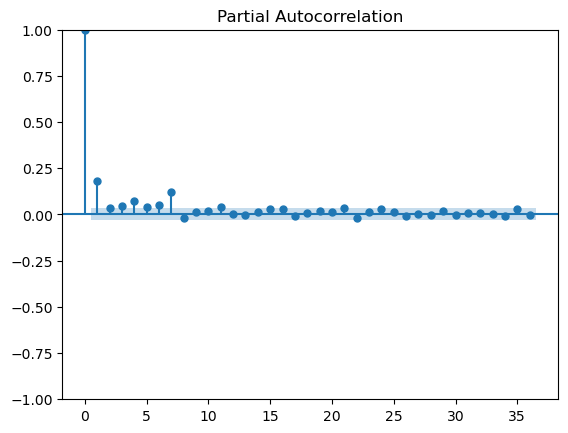

In [6]:
plot_pacf(returns ** 2)
plt.show()

Como el corte se realiza luego del 1er lag, se recomienda comenzar con un modelo GARCH(1, 1). Sin embargo, se decide iniciar por un GARCH(2, 2) para anular los coeficientes que no sean necesarios (por si el mejor ajuste es con $p=1,q=2$ o $p=2,q=1$).

## 5. Ajustar GARCH(p, q)

Tal y como mencionamos antes, comenzaremos ajustando un modelo GARCH(2, 2):

In [7]:
model = arch_model(returns, p=2, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 20433.45858877388
Iteration:      2,   Func. Count:     18,   Neg. LLF: 10733.491485262031
Iteration:      3,   Func. Count:     27,   Neg. LLF: 11733.271230978664
Iteration:      4,   Func. Count:     36,   Neg. LLF: 9856.222137540724
Iteration:      5,   Func. Count:     44,   Neg. LLF: 9605.972547367126
Iteration:      6,   Func. Count:     52,   Neg. LLF: 9710.637972257806
Iteration:      7,   Func. Count:     60,   Neg. LLF: 9671.450932924186
Iteration:      8,   Func. Count:     68,   Neg. LLF: 9593.89537185129
Iteration:      9,   Func. Count:     76,   Neg. LLF: 9587.159831308129
Iteration:     10,   Func. Count:     83,   Neg. LLF: 9586.989546445637
Iteration:     11,   Func. Count:     90,   Neg. LLF: 9587.594294020415
Iteration:     12,   Func. Count:     98,   Neg. LLF: 9586.780099333526
Iteration:     13,   Func. Count:    105,   Neg. LLF: 9586.77051752905
Iteration:     14,   Func. Count:    112,   Neg. LLF: 9586.76792

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9586.77
Distribution:                  Normal   AIC:                           19185.5
Method:            Maximum Likelihood   BIC:                           19222.8
                                        No. Observations:                 3657
Date:                Sun, Sep 22 2024   Df Residuals:                     3656
Time:                        19:07:31   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1911  4.747e-02      4.025  5.692e-05 [9.805e-02,  0.284]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7223      0.438      1.650  9.902e-02    [ -0.136,  1.581]
alpha[1]       0.1492  4.419e-02      3.377  7.338e-04  [6.260e-02,  0.236]
alpha[2]   2.2182e-12      0.104  2.137e-11      1.000    [ -0.203,  0.203]
beta[1]        0.4985      0.277      1.801  7.169e-02 [-4.398e-02,  1.041]
beta[2]        0.3072      0.190      1.614      0.107 [-6.590e-02,  0.680]
===========================================================================

Covariance estimator: robust
"""

Con esto, entonces, notamos que $\alpha_2$ **no** es necesario, mientras que los demás sí ($\beta_2$ es discutible pero igualmente está más cerca de $0$ que de $1$, por lo que se mantiene).

In [8]:
model = arch_model(returns, p=1, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 21038.536402170474
Iteration:      2,   Func. Count:     16,   Neg. LLF: 10426.464411119734
Iteration:      3,   Func. Count:     24,   Neg. LLF: 697766657.8206428
Iteration:      4,   Func. Count:     31,   Neg. LLF: 9855.683679137583
Iteration:      5,   Func. Count:     38,   Neg. LLF: 9863.943636776356
Iteration:      6,   Func. Count:     45,   Neg. LLF: 9606.820183346686
Iteration:      7,   Func. Count:     52,   Neg. LLF: 9652.25150667351
Iteration:      8,   Func. Count:     59,   Neg. LLF: 9754.47098060545
Iteration:      9,   Func. Count:     66,   Neg. LLF: 9586.775695876484
Iteration:     10,   Func. Count:     72,   Neg. LLF: 9586.841942664938
Iteration:     11,   Func. Count:     79,   Neg. LLF: 9586.768278170384
Iteration:     12,   Func. Count:     85,   Neg. LLF: 9586.76783022907
Iteration:     13,   Func. Count:     91,   Neg. LLF: 9586.767827658101
Iteration:     14,   Func. Count:     96,   Neg. LLF: 9586.767827

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9586.77
Distribution:                  Normal   AIC:                           19183.5
Method:            Maximum Likelihood   BIC:                           19214.6
                                        No. Observations:                 3657
Date:                Sun, Sep 22 2024   Df Residuals:                     3656
Time:                        19:07:31   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1911  4.790e-02      3.989  6.626e-05 [9.721e-02,  0.285]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.7223      0.224      3.219  1.288e-03   [  0.282,  1.162]
alpha[1]       0.1492  3.031e-02      4.923  8.541e-07 [8.979e-02,  0.209]
beta[1]        0.4985      0.131      3.810  1.392e-04   [  0.242,  0.755]
beta[2]        0.3072      0.127      2.412  1.584e-02 [5.762e-02,  0.557]
==========================================================================

Covariance estimator: robust
"""

Ahora, como los valores de probabilidad de los coeficientes son muy cercanos a $0$, entonces se conservan, por lo que nos quedamos con este modelo GARCH(1, 2).

## 6. Rolling Forecast

Ahora, si queremos ver en un gráfico que la volatilidad efectivamente se adecúa a esta serie que estamos modelando, entonces hacemos lo siguiente:

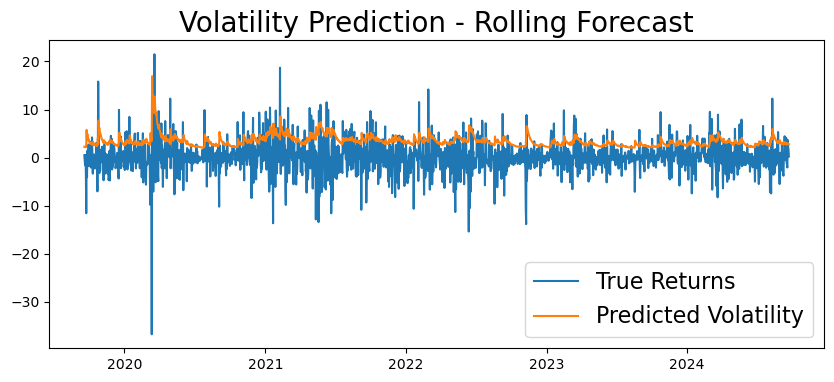

In [9]:
# Creamos el ajuste de nuestro modelo
rolling_predictions = []
test_size = 366 * 5

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1, :][0]))

rolling_predictions = pd.Series(
    rolling_predictions, index=returns.index[-test_size:])

# Graficamos los resultados
plt.figure(figsize=(10, 4))

true, = plt.plot(returns[-test_size:])
preds, = plt.plot(rolling_predictions)

plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)

plt.show()

Gracias a lo cual podemos notar que  ajusta correctamente la serie de valores de volatilidad a los retornos para el período 2020 - 2024 si tenemos como *datos de entrenamiento* el período 2014 - 2019.

## 7. Predecir 5 días

Con todo esto en mente, como ya elegimos el modelo correcto de GARCH para el cálculo de la volatilidad, y también chequeamos que ajuste correctamente a nuestra serie, entonces podemos proceder con la predicción de los valores.

Lo que se va a realizar en este punto es predecir cómo va a ser la volatilidad de los próximos 5 días en base a los datos que tenemos como *historia* (2014 - 2024):

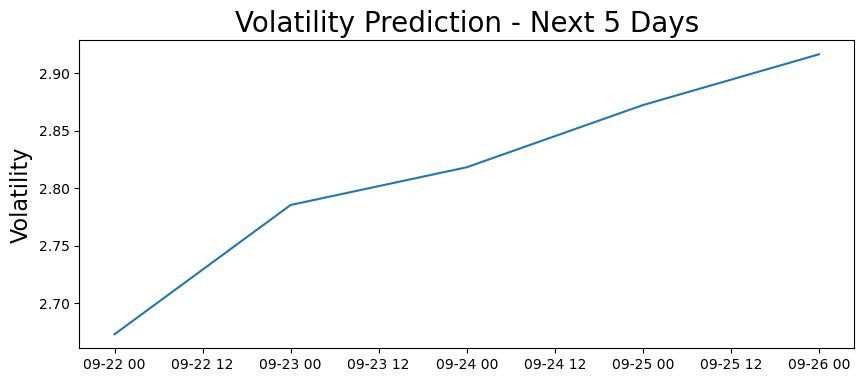

In [10]:
# Entrenamos el modelo
train = returns
model = arch_model(train, p=1, q=2)
model_fit = model.fit(disp='off')

# Hacemos la predicción
horiz = 5
pred = model_fit.forecast(horizon=horiz)
future_dates = [returns.index[-1] +
                timedelta(days=i) for i in range(1, horiz+1)]
pred = pd.Series(np.sqrt(pred.variance.values[-1, :]), index=future_dates)

# Graficamos los resultados
plt.figure(figsize=(10, 4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 5 Days', fontsize=20)
plt.ylabel('Volatility', fontsize=16)
plt.show()

Por lo que notamos que la predicción que se realizó tiene una tendencia positiva. Si queremos ver cómo se comporta esta predicción en base a los últimos 30 días registrados del mes (para visualizarla de mejor modo), entonces podemos hacer lo siguiente:

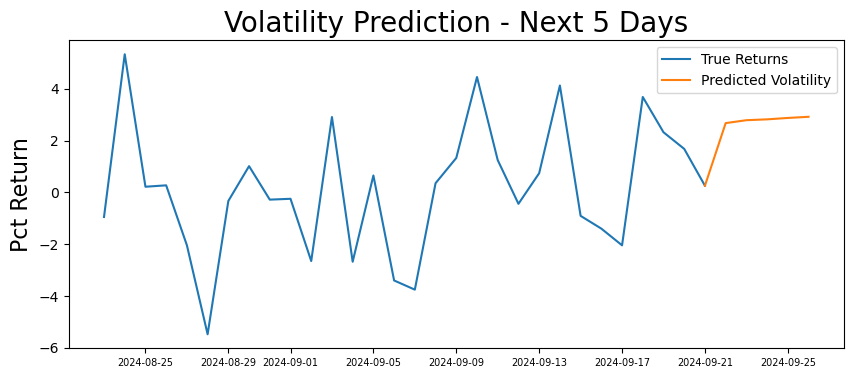

In [11]:
plt.figure(figsize=(10, 4))

plt.plot(returns[-30:])
plt.plot(pd.concat([returns[-1:], pred]))

plt.ylabel('Pct Return', fontsize=16)
plt.xticks(fontsize=7)

plt.legend(['True Returns', 'Predicted Volatility'])
plt.title('Volatility Prediction - Next 5 Days', fontsize=20)

plt.show()

Con ello, entonces, podemos notar que lo que se utilizó para predecir es el nivel de la volatilidad y la tendencia que esta tiene en el último período de tiempo.

Podemos ver esto si ampliamos el período al último medio año registrado:

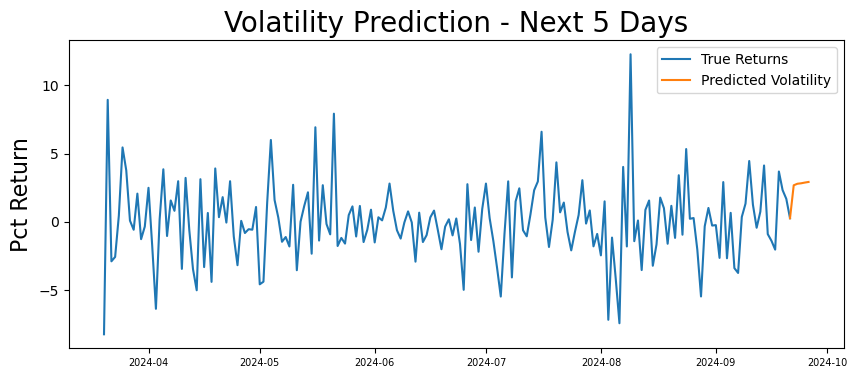

In [12]:
plt.figure(figsize=(10, 4))

plt.plot(returns[-31 * 6:])
plt.plot(pd.concat([returns[-1:], pred]))

plt.ylabel('Pct Return', fontsize=16)
plt.xticks(fontsize=7)

plt.legend(['True Returns', 'Predicted Volatility'])
plt.title('Volatility Prediction - Next 5 Days', fontsize=20)

plt.show()